In [1]:
from __future__ import print_function
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pickle as pkl
import datetime
import glob
import h5py
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import mne
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import sys

# startTime = datetime.datetime.now()

from tqdm.notebook import tqdm
plt.rcParams['figure.dpi'] = 300

In [2]:
kid_info = pd.read_csv('/Users/dbernardo/Documents/pyres/sgm_sbi/csv_info/kid_sessions.csv')

In [3]:
sfreq=512

from fooof.utils import trim_spectrum, interpolate_spectrum

/var/folders/13/039hqcxx7kl4xk4tx4tld34w0000gn/T/ipykernel_37488/1500798629.py:3: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum, interpolate_spectrum


In [4]:
from scipy.signal import savgol_filter


In [5]:
kid_dir = "/Users/dbernardo/Documents/pyres/sgm_sbi/spectra/kid_psds/"

subj_files = glob.glob(os.path.join(kid_dir, '*psd.npy'))

freqs = np.load(subj_files[0].replace('psd.', 'freqs.'))

ages = []
psd_dct = {}
psd_lst = []
for subj_file in subj_files:
    subj_name = subj_file.split('/')[-1].split('_psd.npy')[0]
    age = kid_info[kid_info['subject_id'] == subj_name].age.values[0]

    if age in psd_dct.keys():
        age += np.round(np.random.random(),3)
    assert age not in psd_dct.keys()
    ages.append(age)

    psd = np.load(subj_file)
    psd = psd.mean(axis=(0,1))

    interp_range = [57, 65]
    freqs_int1, psd = interpolate_spectrum(freqs, psd, interp_range)

    psd = 20. * np.log10(psd)
    
    # psd = savgol_filter(psd, 9, 1)
    
    psd_dct[age] = psd
    psd_lst.append(psd)
        
    ages.append(age)


    


/Users/dbernardo/Documents/pyres/eegres_env/lib/python3.8/site-packages/fooof/utils/data.py:132: RuntimeWarning: divide by zero encountered in log10
  ys1 = np.log10(powers[ii1-buffer:ii1])
/Users/dbernardo/Documents/pyres/eegres_env/lib/python3.8/site-packages/fooof/utils/data.py:133: RuntimeWarning: divide by zero encountered in log10
  ys2 = np.log10(powers[ii2:ii2+buffer])
/var/folders/13/039hqcxx7kl4xk4tx4tld34w0000gn/T/ipykernel_37488/2188671600.py:25: RuntimeWarning: divide by zero encountered in log10
  psd = 20. * np.log10(psd)


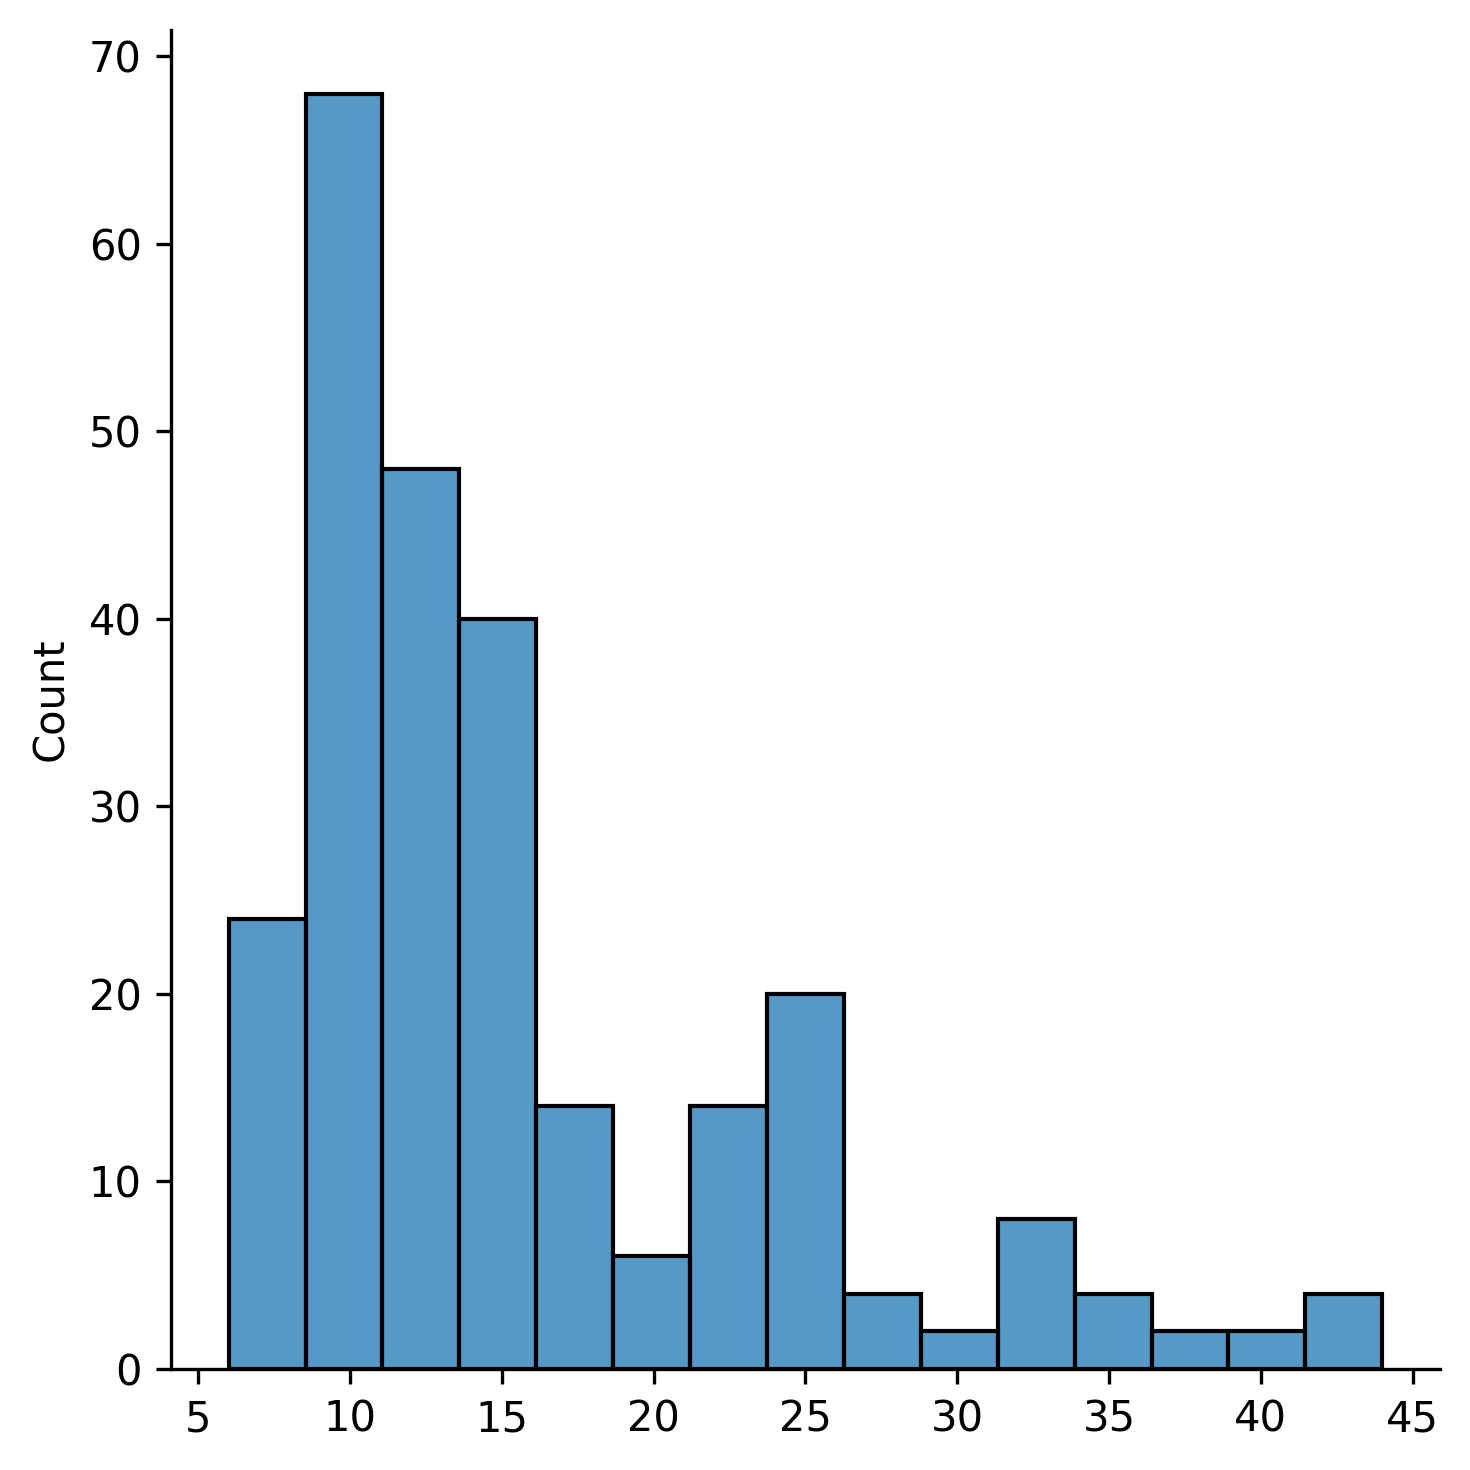

In [6]:
sns.displot(ages)

In [7]:
specs_ = [] 
for k,v in psd_dct.items():
    if k >=5 and k < 9:
        specs_.append(v)

In [8]:
spec_df = pd.DataFrame(specs_)

In [9]:
spec_df = spec_df.rename_axis("subjs", axis="index")
spec_df = spec_df.rename_axis("freq", axis="columns")

In [10]:
freqs_r = [np.round(f,2) for f in freqs]
freqs_dct_map = {}
for n, f in enumerate(freqs_r):
    freqs_dct_map[n] = f

In [11]:
spec_df = spec_df.rename(columns=freqs_dct_map)


<Axes: xlabel='freq', ylabel='power'>

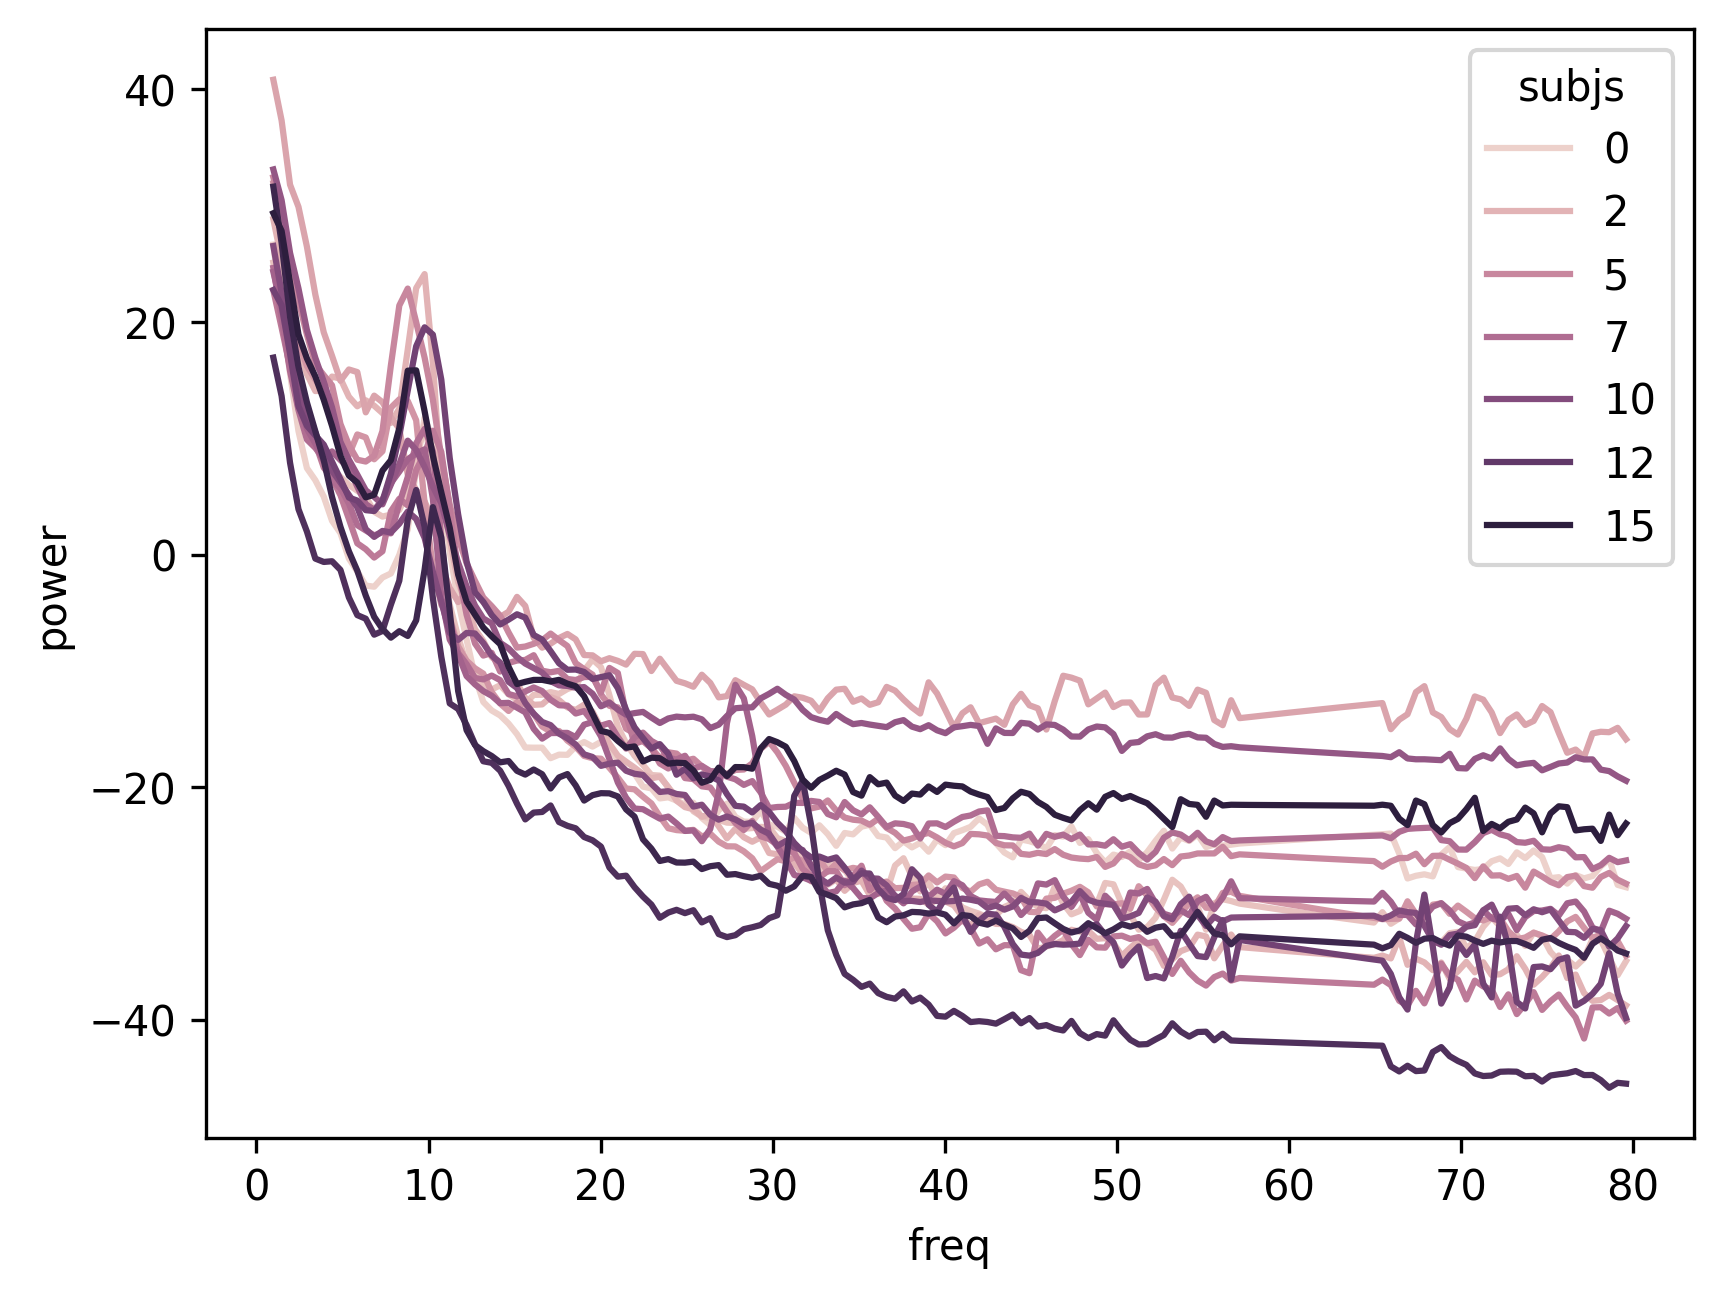

In [15]:

# Assuming your DataFrame is named spec_df
long_df = pd.melt(spec_df.reset_index(), id_vars=['subjs'], var_name='freq', value_name='power')

# Plotting
sns.lineplot(data=long_df, x='freq', y='power', hue='subjs')


<Axes: xlabel='freq', ylabel='power'>

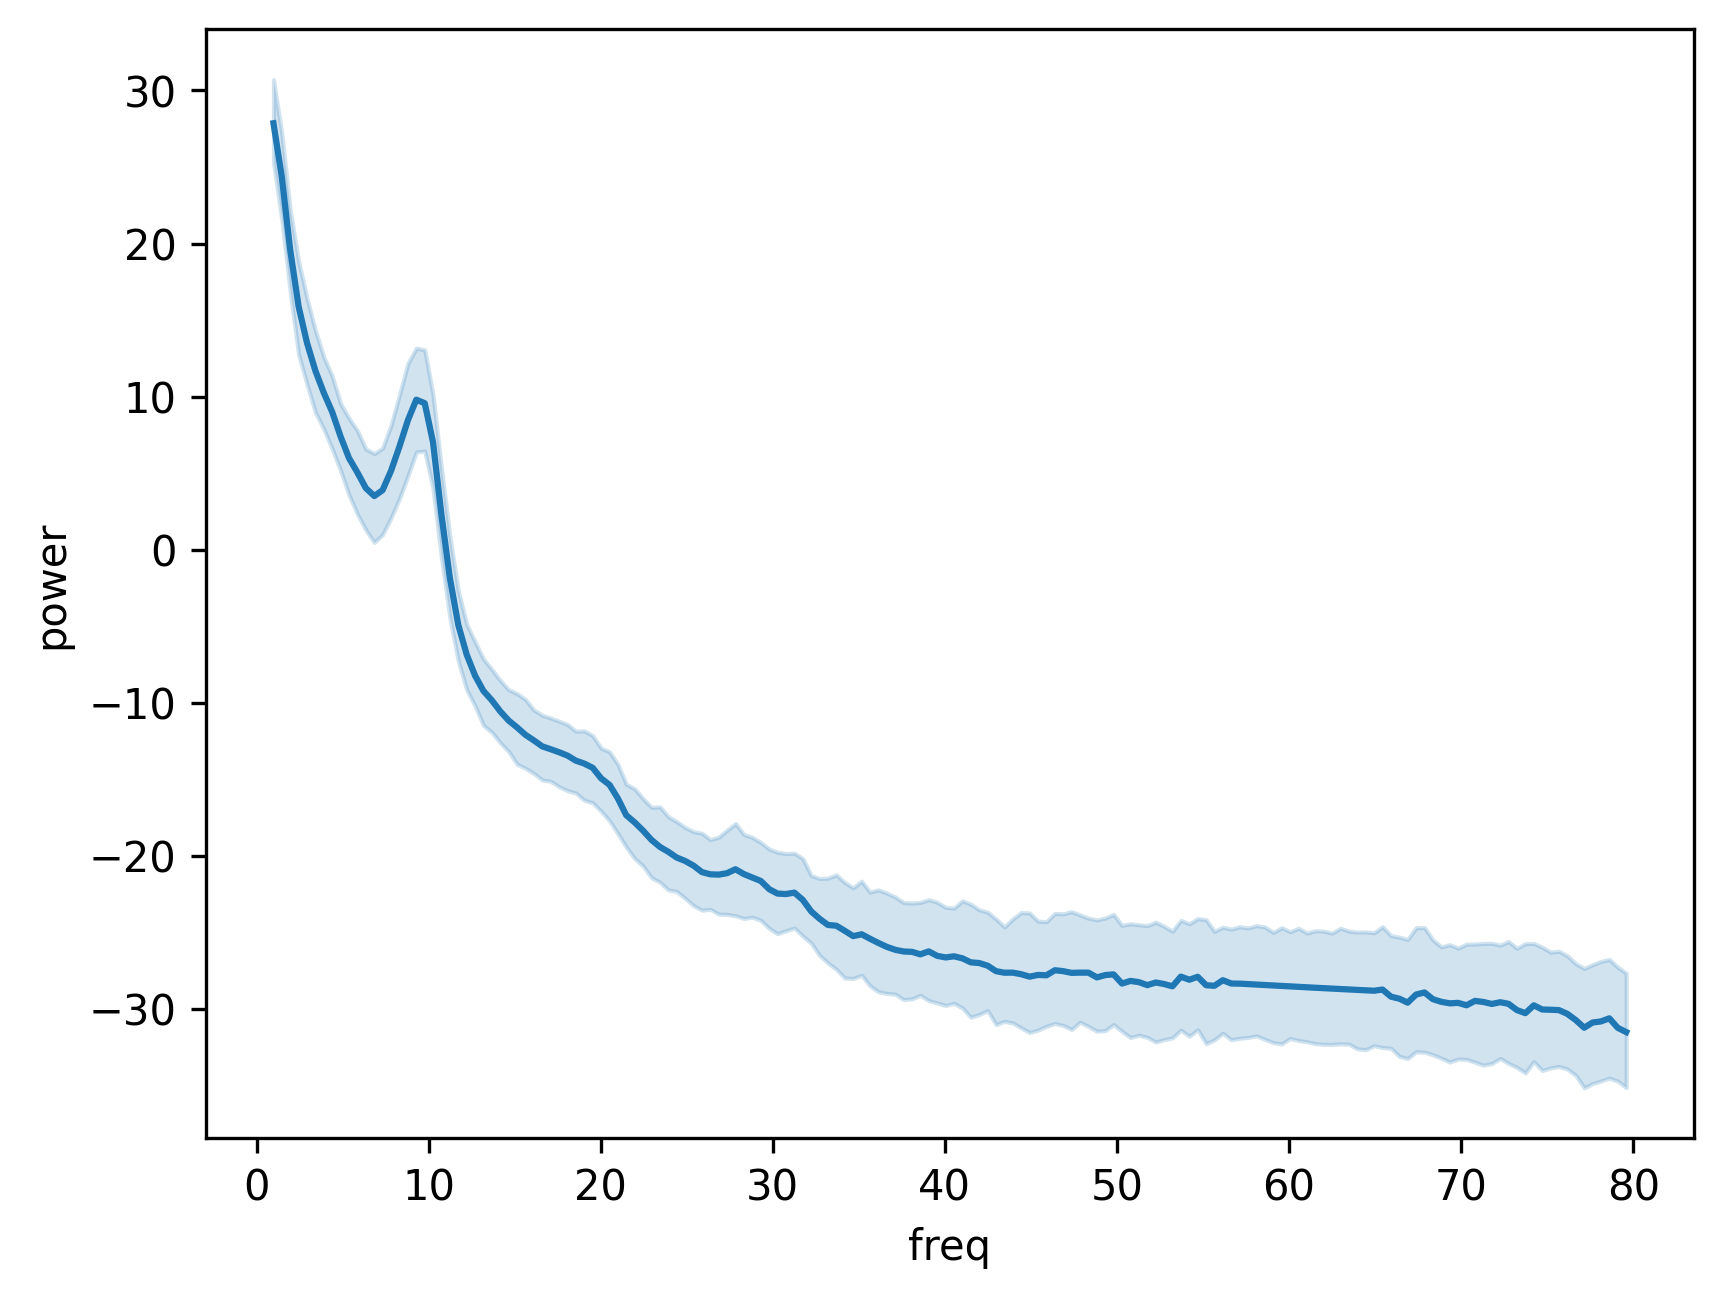

In [16]:
sns.lineplot(data=long_df, x='freq', y='power')
# plt.yscale('log')


In [17]:
raw_dir = '/Users/dbernardo/Documents/pyres/__SPQR_data/data'

_, spasms_subjs, _ = next(os.walk(raw_dir))
fmin = 0.5 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 59
num_freqs=118
freq_range = [0.5, fmax] # can't use 0.5 as fmin b/c it is freq bin size with Welch
fvec = np.linspace(fmin,fmax,num_freqs) # np.linspace(0.8, 40, 197)


In [18]:

eeg_files = glob.glob('./data/*.edf')
sfreq = 512
for eeg_file in eeg_files:
    raw = mne.io.read_raw_edf(eeg_file)
    psd = raw.compute_psd(method='welch', fmin=0.1, fmax=80, verbose='warning', n_fft=1024)
    # psd_av = np.mean(psd, axis=0)

    # plt.yscale('log')
    
    # plt.figure()
    # xr = np.arange(0,ds_arr.shape[1])/200
    # for n, arr in enumerate(ds_arr):
    #     plt.plot(xr[:40000], arr[:40000] + n*.001)


Extracting EDF parameters from /Users/dbernardo/Documents/pyres/spec_norm/data/RM_spectral_analysis.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/13/039hqcxx7kl4xk4tx4tld34w0000gn/T/ipykernel_37488/3320015668.py:4: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(eeg_file)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


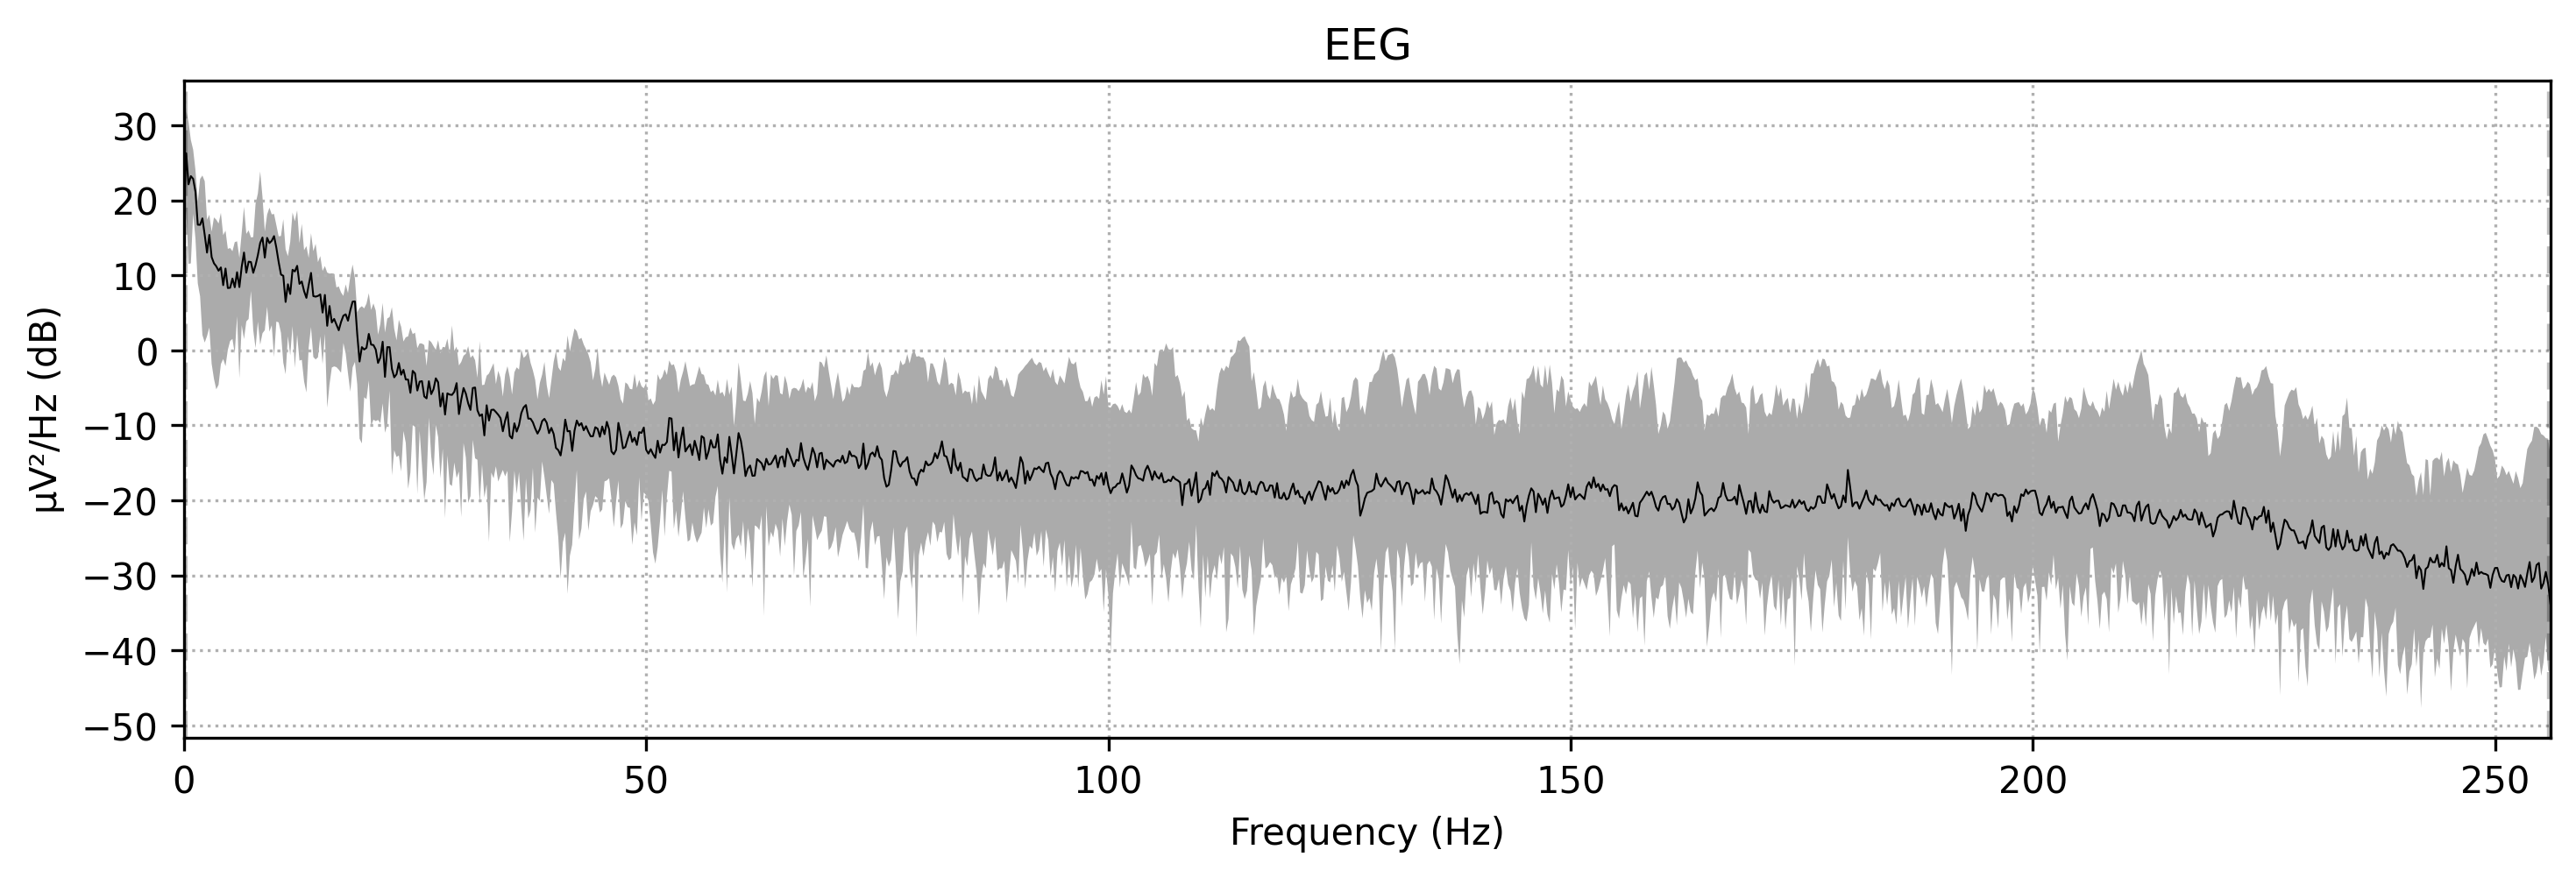

In [19]:
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)


In [20]:
subj_spec_av = np.mean(psd.get_data(), axis=0)

In [25]:
long_df

,subjs,freq,power
0,0,0.98,26.658451
1,1,0.98,25.105529
2,2,0.98,28.844304
3,3,0.98,40.834342
4,4,0.98,31.924284
...,...,...,...
2587,11,79.59,-39.839003
2588,12,79.59,-inf
2589,13,79.59,-45.496894
2590,14,79.59,-34.300310


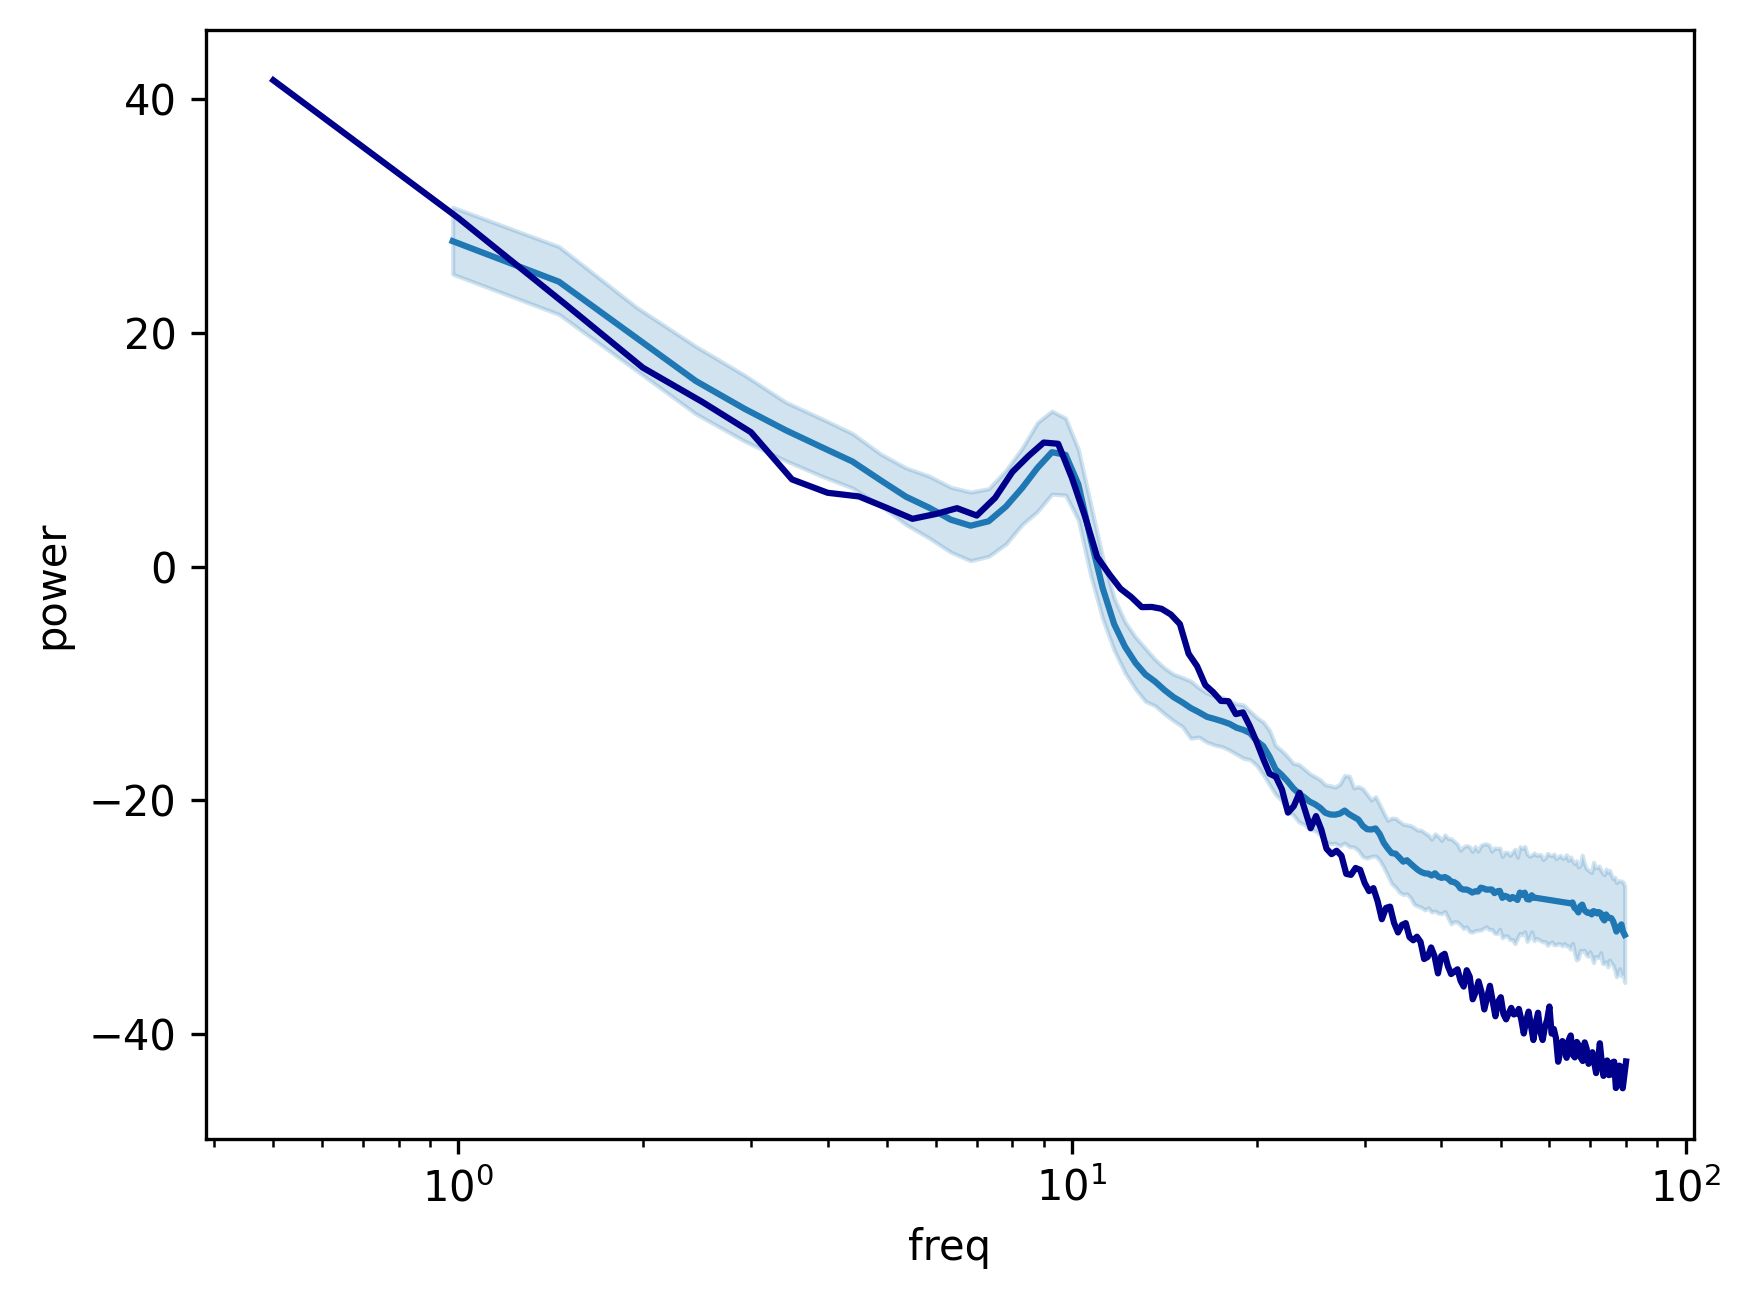

In [55]:
plt.figure()

long_df_norm = long_df.copy()
long_df_norm['power'] = long_df_norm['power']
sns.lineplot(data=long_df_norm, x='freq', y='power')

subj_spec_av_db = 20. * np.log10(subj_spec_av)

plt.plot(psd.freqs, subj_spec_av_db + 219, color='darkblue')
plt.xscale('log')
plt.show()

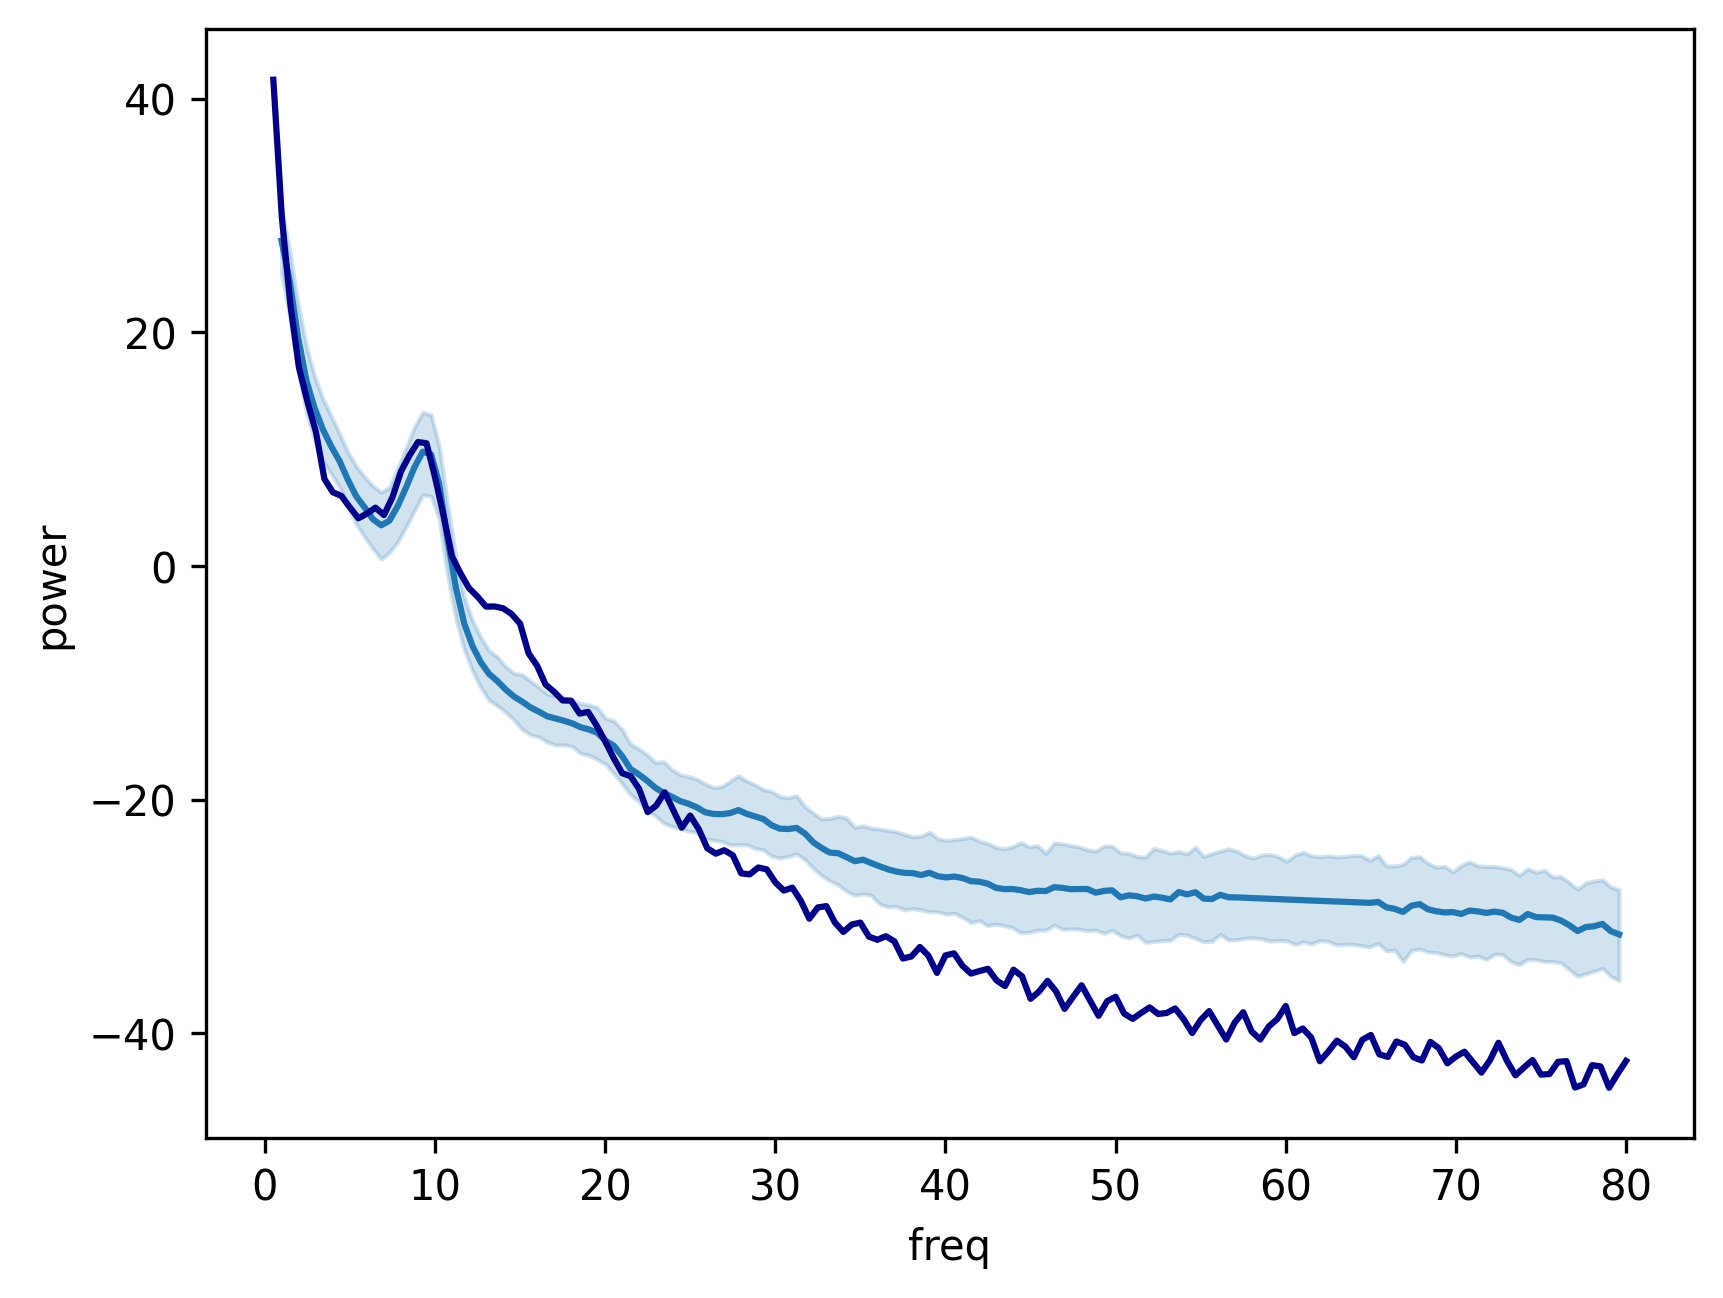

In [54]:
plt.figure()

long_df_norm = long_df.copy()
long_df_norm['power'] = long_df_norm['power']
sns.lineplot(data=long_df_norm, x='freq', y='power')

subj_spec_av_db = 20. * np.log10(subj_spec_av)

plt.plot(psd.freqs, subj_spec_av_db + 219, color='darkblue')
# plt.xscale('log')
plt.show()